# Testing out $m_{hh}^{cor}$

**Goal:** Rafael said that $m_{hh}^{cor}$ should work better for the resolved analysis - so I'm going to test it out!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import itertools
import h5py

import uproot

import os
os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, getExpectedBand, getBkgSysBand
from AnalysisUtils import getLambdaWeights, hackHistogram, getHelicityAnglesRR
from plotting import sig_bkg_massplanes, plot_MDpT, plot2dSig, plotSigBkg
from analysis import read_tsv

os.sys.path.append('../eda_tools')
from NN_RW import getNNweights

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

**Load in the data**

In [11]:
fDir = "../../hh4b/hh4b-resolved-reconstruction" 

lumi15 = 3.2195
lumi16 = 24.5556
lumi = lumi15+lumi16

sdf = nanoToDf(f"{fDir}/sm_pT20.root",   ttree="fullmassplane")
bdf = nanoToDf(f"{fDir}/dat16_pT20.root",ttree="fullmassplane")

print(np.min(sdf.run_number),np.max(sdf.run_number))
sdf = sdf[sdf.run_number > 296939]

sdf['mc_sf'] *= lumi

fullmassplane
fullmassplane
276262 311481


But for this study - I only events with four jets with $p_T$ > 40 GeV.

In [12]:
# Derive the new variables that Sean suggested
bdf['dPhi_h1'] = np.arccos(np.cos(bdf.phi_h1_j1 - bdf.phi_h1_j2))
bdf['dPhi_h2'] = np.arccos(np.cos(bdf.phi_h2_j1 - bdf.phi_h2_j2))

bdf['dPhi_hh'] = np.arccos(np.cos(bdf.phi_h1 - bdf.phi_h2))
bdf['dR_hh'] = np.sqrt( bdf['dPhi_hh']**2 + (bdf.eta_h1 - bdf.eta_h2)**2 )

In [17]:
pT_cut = 40
nHidden = 50

In [14]:
sdf = sdf[np.min(sdf[[f'pT_h{i}_j{j}' for i in [1,2] for j in [1,2]]],axis=1) > pT_cut]
bdf = bdf[np.min(bdf[[f'pT_h{i}_j{j}' for i in [1,2] for j in [1,2]]],axis=1) > pT_cut]

**Retrieve the background estimate**

In [18]:
sort_rw_cols=['pT_4_log', 'pT_2_log','eta_i', 'dRjj_1_log', 'dRjj_2_log', 
              'njets', 'pt_hh_log', 'X_wt_log', 'dR_hh', 'dPhi_h1', 'dPhi_h2']

modelName = f"models/data16_mdr_dl1r_77/MAR20_dPhi_HCs_pT_{pT_cut}_nHidden_{nHidden}.h5"

getNNweights(bdf, kinematic_region=2,
             sort_rw_cols=sort_rw_cols, nHidden=nHidden,
             epochs = 80, patience=10, train=False,
             modelName=modelName)

Instructions for updating:
Colocations handled automatically by placer.
rw 2b yield 12380.423
4b yield 11860


**Make the pretty $m_{hh}$ plot** 

In [19]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])
x = 0.5*(edges[:-1]+edges[1:])

labels = ['min jet $p_T$ > 40 GeV', 'min jet 30 GeV < $p_T$ < 40 GeV', 'min jet 25 GeV < $p_T$ < 30 GeV']
yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=labels)

In [24]:
bdf.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt',
       'X_wt_2', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2',
       'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1',
       'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1',
       'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'dPhi_h1', 'dPhi_h2', 'dPhi_hh', 'dR_hh', 'pT_4_log',
       'pT_2_log', 'dRjj_1_log', 'dRjj_2_log', 'pt_hh_log', 'X_wt_log',
       'NN_w_2b', 'm_hh_cor2'],
   

In [22]:
for df in [sdf,bdf]:
    df['m_hh_cor2'] = df['m_hh'] - df['m_h1'] - df['m_h2'] + 250

In [28]:
text = '$\mathbf{ATLAS}$ 2016 data Internal\n'
text += 'FEB20 MNT, NNT mod from MAR20.2\n'
text += 'DL1r at 77% WP, MDR + min $D_{hh}$'

In [51]:
labels = ['m_hh','m_hh_cor','m_hh - m_h1 - m_h2 + 250']

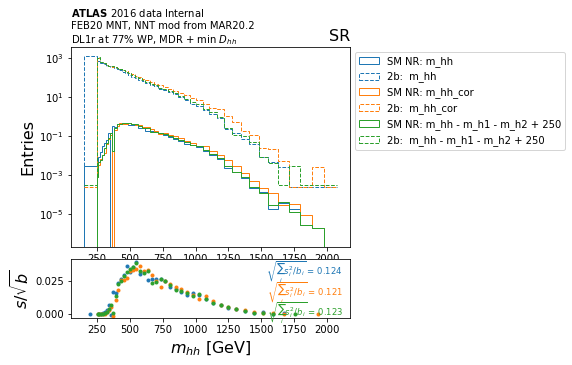

In [53]:
# Make the mhh histogram for the signal
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

sig_mask = (sdf.ntag>=4) & (sdf.kinematic_region==0)
bkg_mask = (bdf.ntag==2) & (bdf.kinematic_region==0) 

for k, c, l, ytxt in zip(range(3), ['m_hh','m_hh_cor','m_hh_cor2'], labels, [1, 0.65, 0.3]):

    color = f'C{k}'
    
    # signal
    si,_,_ = ax1.hist(sdf.loc[sig_mask,c],
                      edges,color=color,histtype='step',log=True,
                      label="SM NR: "+l,ls='-',
                      weights=sdf.loc[sig_mask,'mc_sf'])

    # background
    bi,_,_ = ax1.hist(bdf.loc[bkg_mask,c],
                      edges,color=color,histtype='step',log=True,
                      label="2b:  "+l,ls='--',
                      weights=bdf.loc[bkg_mask,'NN_w_2b'])

    # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
    ax2.plot(x[bi!=0],si[bi!=0]/np.sqrt(bi[bi!=0]),marker='.',color=color,linewidth=0)

    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

    ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(si[bi!=0]**2 / bi[bi!=0]))),
             ha='right',va='top',fontsize=8.5,
             transform=ax2.transAxes,color=color)
    
#     band = getExpectedBand(list(si), list(bi), mu_tests)
#     stats.loc[bidx,l] = band
    
# Text per subfig
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('SR', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/dl1r_77/m_hh_cor2.pdf',bbox_inches='tight')

plt.show()

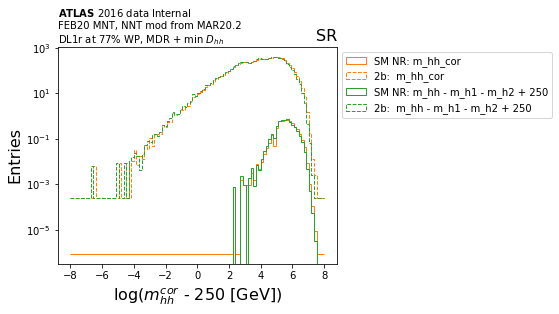

In [62]:
# Make the mhh histogram for the signal
fig = plt.figure(figsize=(5, 4))
ax1 = fig.gca()

cutoff = 250
for color, c, l in zip(['C1','C2'], ['m_hh_cor','m_hh_cor2'], labels[1:]):
    
    # signal
    si,_,_ = ax1.hist(np.log(sdf.loc[sig_mask,c] - cutoff),
                      100,(-8,8),color=color,histtype='step',log=True,
                      label="SM NR: "+l,ls='-',
                      weights=sdf.loc[sig_mask,'mc_sf'])

    # background
    bi,_,_ = ax1.hist(np.log(bdf.loc[bkg_mask,c] - cutoff),
                      100,(-8,8),color=color,histtype='step',log=True,
                      label="2b:  "+l,ls='--',
                      weights=bdf.loc[bkg_mask,'NN_w_2b'])
    
# Text per subfig
ax1.set_xlabel('$\log ( m_{hh}^{cor}$ - 250 [GeV])',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('SR', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/dl1r_77/log_m_hh_cor2.pdf',bbox_inches='tight')

plt.show()

**Plan:** Vary the cutoff, and evaluate the best fits with a Gaussian

In [79]:
colors = ['C6','C0','C1','C4','C3','C2']
cutoffs = [225,230,235,240,245,250]

In [71]:
cutoffs

250

225
230
235
240
245
250


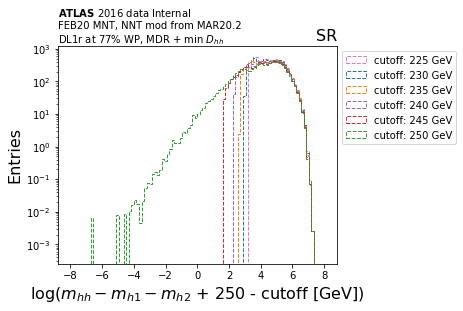

In [81]:
fig = plt.figure(figsize=(5, 4))
ax1 = fig.gca()

for color, cutoff in zip(colors,cutoffs):
    print(cutoff)
    bi,_,_ = ax1.hist(np.log(bdf.loc[bkg_mask,c] - cutoff),
                      100,(-8,8),color=color,histtype='step',log=True,
                      label=f"cutoff: {cutoff} GeV",ls='--',
                      weights=bdf.loc[bkg_mask,'NN_w_2b']) 
    
ax1.set_xlabel('$\log ( m_{hh} - m_{h1}-m_{h2}$ + 250 - cutoff [GeV])',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('SR', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/dl1r_77/log_m_hh_cor2_varyCutoff.pdf',bbox_inches='tight')

plt.show()